---
# Implement REINFORCE Algorithm
# **Policy-Gradient Methods**
###DEEP REINFORCEMENT LEARNING
---


Import packages

In [4]:
%%time

# # Configuration the image rendering in colab

# # Taken from
# # https://towardsdatascience.com/rendering-openai-gym-envs-on-binder-and-google-colab-536f99391cc7

# !apt-get install -y xvfb x11-utils &> /dev/null

# !pip install pyvirtualdisplay==0.2.* \
#              PyOpenGL==3.1.* \
#              PyOpenGL-accelerate==3.1.* &> /dev/null

# !pip install gym[box2d]==0.17.* &> /dev/null

# # Taken from https://github.com/actions/virtual-environments/issues/214
# !sudo apt-get update  &> /dev/null
# !sudo apt-get install xvfb --fix-missing &> /dev/null

# import pyvirtualdisplay

# _display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
# _ = _display.start()

# !echo $DISPLAY # sanity checking: should be set to some value (e.g. 1005)

# from IPython import display

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


In [5]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## OpenAI Gym's Cartpole Environment

In [7]:
%%time

def set_seed(env, seed):
    env.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def make_environment(env_name='CartPole-v0', seed=20):
    env = gym.make(env_name)
    set_seed(env, seed)
    print('observation space:', env.observation_space)
    print('action space:', env.action_space)
    print('threshold: ', env.spec.reward_threshold)
    return env

# env = make_environment()

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 2.86 µs


## Model

In [9]:
%%time

def create_network(env):
    obs_size = env.observation_space.shape[0]
    n_actions = env.action_space.n
    HIDDEN_SIZE = 256

    model = torch.nn.Sequential(
              torch.nn.Linear(obs_size, HIDDEN_SIZE),
              torch.nn.ReLU(),
              torch.nn.Linear(HIDDEN_SIZE, n_actions),
              torch.nn.Softmax(dim=0)
      )

    print (model)
    return model

# model = create_network(env)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 2.86 µs


## The REINFORCE training

In [11]:
%%time

def add_observation(ob_data, trajectory, curr_state, action, reward):
    if trajectory not in observation_data:
        ob_data[trajectory] = []

    temp = list(curr_state)
    temp.append(action)
    temp.append(reward)
    ob_data[trajectory].append(temp)
    return ob_data

def calculate_reward(reward_penalty, state, reward, action, transitions):

    past_transition_actions = [a for (s,a,r) in transitions]

    if reward_penalty:
        # if action == 0:
        #   # pole angle
        #   correction = -1 if abs(state[2]) < 0.1 else 1
        # else: 
        #   correction = 1 if abs(state[2]) < 0.1 else -1
        # return correction
        tolerance = 3
        size = 10
        if len(past_transition_actions)>size:
            if (sum(past_transition_actions[-size:])<tolerance and action==0) or (sum(past_transition_actions[-size:])>size-tolerance and action==1):
                return -1
            # if (sum(past_transition_actions[-size:]) < size/2 and action==0) or (sum(past_transition_actions[-size:])>size/2 and action==1):
            #     return 1
        return 1

    else:
        return reward

def train_reinforce(env, model, gamma=0.99, learning_rate=0.003, epoch=500, return_data=False, reward_penalty=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 200 for V0 and 500 for V1 environment
    Horizon = 200
    score = []

    observation_data = {}

    for trajectory in range(epoch):

        curr_state = env.reset()
        if return_data:
            observation_data = add_observation(observation_data, trajectory, curr_state, 0, 0)
        done = False
        transitions = []

        acc_reward = 0
        for t in range(Horizon):
            act_prob = model(torch.from_numpy(curr_state).float())
            action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy())
            prev_state = curr_state
            curr_state, reward, done, info = env.step(action)

            reward_correction = calculate_reward(reward_penalty, curr_state, reward, action, transitions)
            acc_reward = acc_reward + reward_correction

            transitions.append((prev_state, action, acc_reward))

            if return_data:
                observation_data = add_observation(observation_data, trajectory, curr_state, action, reward)
            if done:
                reward = acc_reward
                break

        if reward_penalty:
            score.append(acc_reward)
        else:
            score.append(len(transitions))
        
        reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,))

        batch_Gvals =[]
        for i in range(len(transitions)):
            new_Gval=0
            power=0
            for j in range(i,len(transitions)):
                new_Gval=new_Gval+((gamma**power)*reward_batch[j]).numpy()
                power+=1
            batch_Gvals.append(new_Gval)
        expected_returns_batch=torch.FloatTensor(batch_Gvals)
        expected_returns_batch /= expected_returns_batch.max()

        state_batch = torch.Tensor([s for (s,a,r) in transitions])
        action_batch = torch.Tensor([a for (s,a,r) in transitions])

        pred_batch = model(state_batch)
        prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze()

        loss = - torch.sum(torch.log(prob_batch) * expected_returns_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if trajectory % 50 == 0 and trajectory>0:
            print('Trajectory {}\tAverage Score: {:.2f}'.format(trajectory, np.mean(score[-50:-1])))

    return model, score, observation_data

# env = make_environment()
# model = create_network(env)
# model, score, observation_data = train_reinforce(env, model, return_data=False, reward_penalty=True)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.05 µs


## Observed data

In [13]:
%%time

def create_observation_dataframe(observation_data, score):
    """
    These floats represent:
    the cart’s horizontal position (0.0 = center),
    its velocity (positive means right),
    the angle of the pole (0.0 = vertical), and
    its angular velocity (positive means clockwise).
    """
    obs_df = pd.DataFrame(columns=['trajectory','sequence','hor_pos','velocity','pole_angle','angular_velocity', 'action', 'reward'])
    for trajectory in range(MAX_TRAJECTORIES):
        for sequence in range(len(observation_data[trajectory])):
            row = [trajectory,sequence]
            row.extend(observation_data[trajectory][sequence])
            obs_df.loc[len(obs_df.index)] = row
    score_df = pd.DataFrame({'trajectory': range(len(score)), 'score': score})
    obs_df1 = pd.merge(obs_df, score_df, on='trajectory')
    return obs_df1

#obs_df = create_observation_dataframe(observation_data, score)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


## Plot the Training Scores

In [15]:
%%time

def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

def plot_training_results(score):

    score = np.array(score)
    avg_score = running_mean(score)

    plt.figure(figsize=(15,7))
    plt.ylabel("Trajectory Duration",fontsize=12)
    plt.xlabel("Training Epochs",fontsize=12)
    plt.plot(score, color='gray' , linewidth=1)
    plt.plot(avg_score, color='blue', linewidth=3)
    plt.scatter(np.arange(score.shape[0]),score, color='green' , linewidth=0.3)
    plt.show()
    
# plot_training_results(score)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 2.86 µs


## Render Cartpole Environment

In [17]:
%%time

def watch_agent():
    env = gym.make('CartPole-v0')
    state = env.reset()
    rewards = []
    img = plt.imshow(env.render(mode='rgb_array'))
    for t in range(2000):
        pred = model(torch.from_numpy(state).float())
        action = np.random.choice(np.array([0,1]), p=pred.data.numpy())

        img.set_data(env.render(mode='rgb_array'))
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)

        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            print("Reward:", sum([r for r in rewards]))
            break
    env.close()

# watch_agent()

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.86 µs


## Test results

In [19]:
%%time


def test_agent(print_reward=False):
    env = gym.make('CartPole-v0')
    state = env.reset()
    rewards = []
    obs=[]
    for t in range(2000):
        pred = model(torch.from_numpy(state).float())
        prev_state = state
        action = np.random.choice(np.array([0,1]), p=pred.data.numpy())
        state, reward, done, _ = env.step(action)
        obs.append([prev_state,state,action])

        rewards.append(reward)
        if done:
            rew = sum([r for r in rewards])
            if print_reward:
                print("Reward:", rew)
            return rew
    env.close()


# test_agent()


CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 3.1 µs


In [20]:
# test_df['success'].value_counts().plot(kind='bar')

def plot_test_results(total=100):
    test_scores = []
    for i in range(total):
        test_scores.append(test_agent())

    print(test_scores)

    test_df= pd.DataFrame({'test':range(total), 'score':test_scores})
    test_df['success'] = test_df['score'].apply(lambda x: x>195)
    print(test_df['score'].describe())
    c = test_df['success'].value_counts()
    print(c)
    # ax = sns.barplot(c)
    # ax.bar_label(ax.containers[0], fontsize=10);
    # plt.show()
    sns.relplot(data=test_df, x="test", y="score", hue="success", size="success")
    plt.show()

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)
threshold:  195.0
Sequential(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=2, bias=True)
  (3): Softmax(dim=0)
)


<timed exec>:87: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)


Trajectory 50	Average Score: 38.00
Trajectory 100	Average Score: 62.06
Trajectory 150	Average Score: 68.61
Trajectory 200	Average Score: 74.04
Trajectory 250	Average Score: 91.96
Trajectory 300	Average Score: 133.06
Trajectory 350	Average Score: 134.90
Trajectory 400	Average Score: 165.16
Trajectory 450	Average Score: 183.67


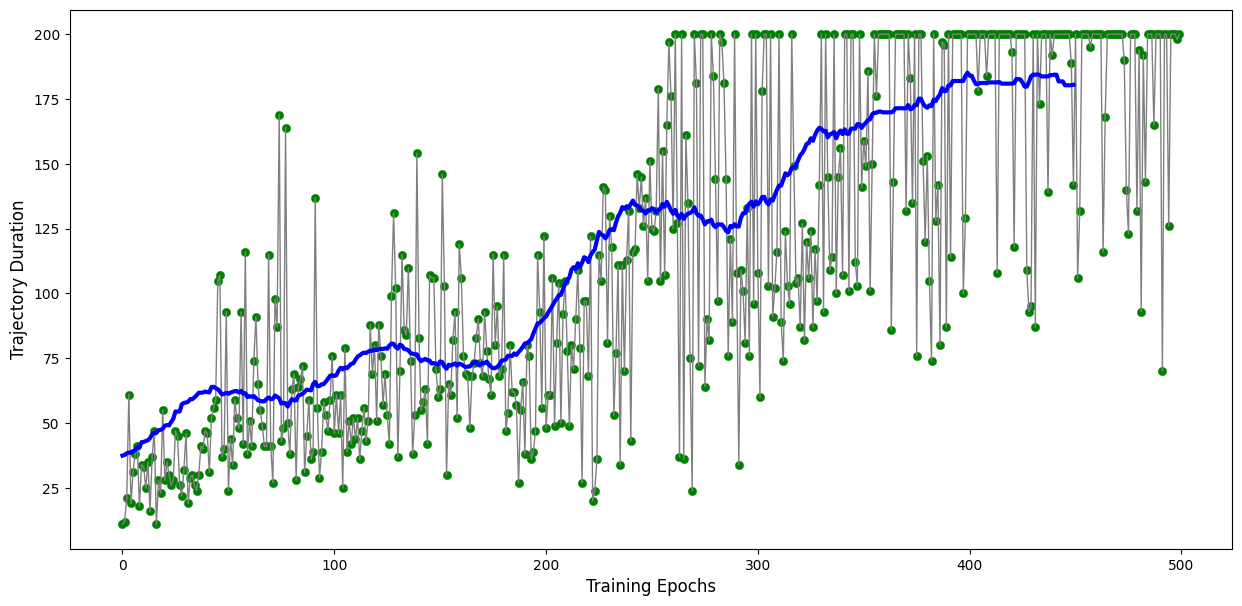

[200.0, 200.0, 116.0, 200.0, 200.0, 200.0, 200.0, 200.0, 176.0, 200.0, 200.0, 200.0, 86.0, 200.0, 186.0, 179.0, 200.0, 200.0, 112.0, 198.0, 200.0, 200.0, 163.0, 200.0, 200.0, 179.0, 106.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 89.0, 200.0, 199.0, 145.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 109.0, 199.0, 200.0, 199.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 92.0, 200.0, 102.0, 200.0, 178.0, 200.0, 200.0, 200.0, 197.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 181.0, 200.0, 200.0, 118.0, 200.0, 200.0, 200.0, 200.0, 200.0, 195.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]
count    100.000000
mean     189.040000
std       28.453016
min       86.000000
25%      200.000000
50%      200.000000
75%      200.000000
max      200.000000
Name: score, dtype: float64
success
True     82
False    18
Name: count, dtype: int64


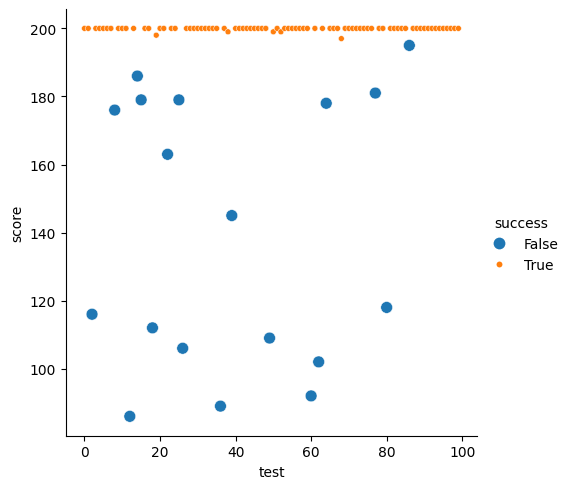

In [21]:
env = make_environment()
model = create_network(env)
model, score, observation_data = train_reinforce(env, model, return_data=False, reward_penalty=False)
plot_training_results(score)
plot_test_results(100)

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)
threshold:  195.0
Sequential(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=2, bias=True)
  (3): Softmax(dim=0)
)
Trajectory 50	Average Score: 37.00
Trajectory 100	Average Score: 48.24
Trajectory 150	Average Score: 49.37
Trajectory 200	Average Score: 55.71
Trajectory 250	Average Score: 56.61
Trajectory 300	Average Score: 69.04
Trajectory 350	Average Score: 113.92
Trajectory 400	Average Score: 150.04
Trajectory 450	Average Score: 189.71


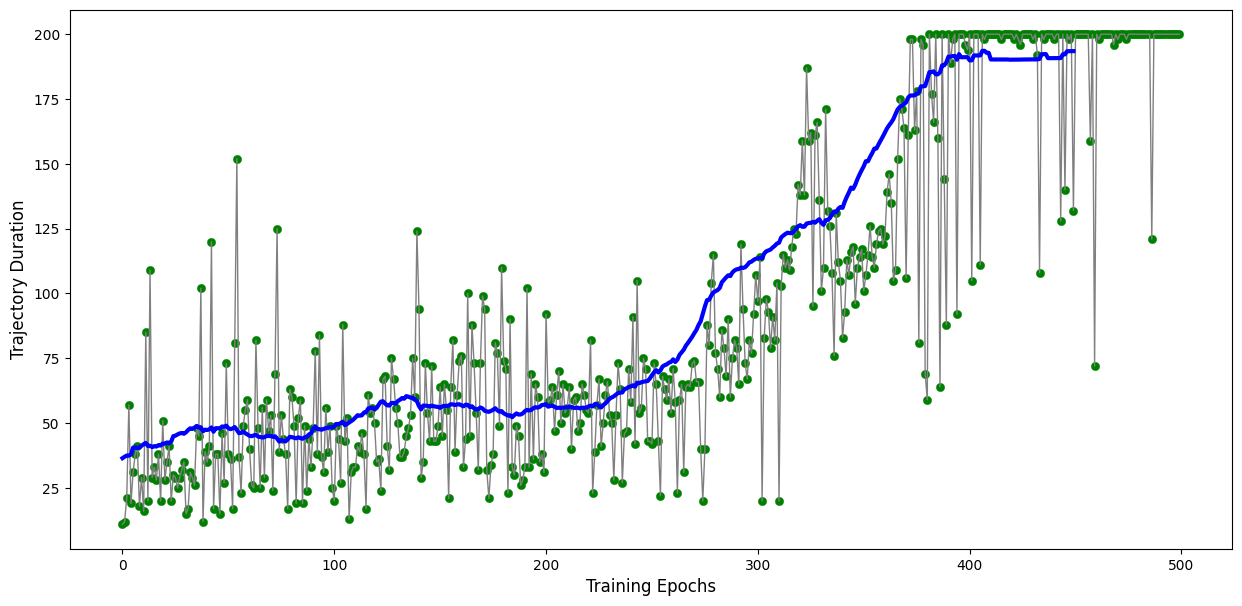

[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 94.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 147.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 135.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 169.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 169.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]
count    100.000000
mean     197.140000
std       13.989188
min       94.000000
25%      200.000000
50%      200.000000
75%      200.000000
max      200.000000
Name: score, dtype: float64
success
True     95
False     5
Name: count, dtype: int64


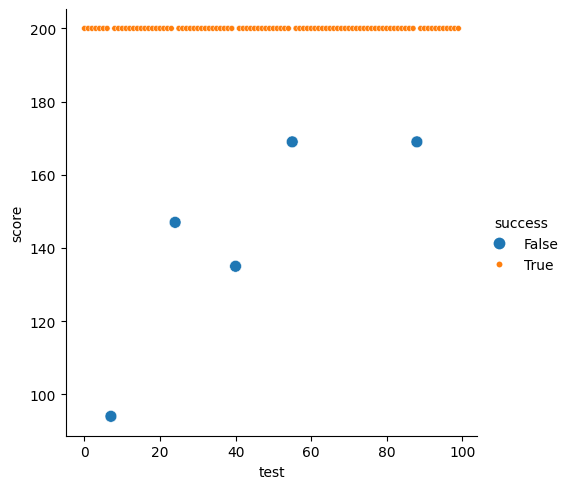

In [22]:
env = make_environment()
model = create_network(env)
model, score, observation_data = train_reinforce(env, model, return_data=False, reward_penalty=True)
plot_training_results(score)
plot_test_results(100)